# 📈 Stock Price Anomaly Detector

This notebook detects anomalous price movements in historical stock data using a **z-score** approach.

- Load stock data from a local CSV **or** fetch live data via the [Alpha Vantage API](https://www.alphavantage.co)
- Choose price type (open / high / low / close / volume)
- Tune the anomaly threshold (number of standard deviations)
- Visualise flagged anomalies on an interactive chart

## 1 · Imports & Setup

In [ ]:
import os
import json
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Optional — only needed for live API fetch
try:
    import requests
    REQUESTS_AVAILABLE = True
except ImportError:
    REQUESTS_AVAILABLE = False
    print("ℹ️  'requests' not installed — live API fetching disabled.")
    print("   Run: pip install requests")

print("✅ Imports complete")

✅ Imports complete


## 2 · Configuration

Edit the variables in this cell to control the analysis.

In [ ]:
# ── Data source ────────────────────────────────────────────────────────────
# Set CSV_PATH to a file path to load local data, or None to use the API.
CSV_PATH = "NFLX.csv"       # e.g. "NFLX.csv" or None

# ── Ticker & date range ────────────────────────────────────────────────────
SYMBOL     = "NFLX"
START_DATE = "2018-01-01"   # YYYY-MM-DD  (ignored when loading from CSV)
END_DATE   = "2023-12-31"   # YYYY-MM-DD

# ── Price column ──────────────────────────────────────────────────────────
# For CSV: exact column name.   For API: one of open/high/low/close/volume
PRICE_COL  = "Close"

# ── Anomaly detection ────────────────────────────────────────────────────
K_THRESHOLD = 2.0           # flag prices > K standard deviations from mean

# ── Alpha Vantage API (only used when CSV_PATH is None) ──────────────────
# Export your key:  export ALPHAVANTAGE_API_KEY="your_key_here"
ALPHAVANTAGE_API_KEY = os.getenv("ALPHAVANTAGE_API_KEY", "demo")
FREQUENCY = "daily"         # daily | weekly | monthly

print("Configuration loaded ✅")

Configuration loaded ✅


## 3 · Load / Fetch Data

In [16]:
# Define your CSV_PATH here
CSV_PATH = 'your_file.csv'  # Replace with your desired CSV filename

# ── Check for CSV existence and upload if not found ─────────────────────
import os

# Check if the CSV_PATH exists
if not os.path.exists(CSV_PATH):
    print(f"⚠️  '{CSV_PATH}' not found in the current directory.")
    print("   Launching file picker — please upload your CSV now...\n")
    try:
        from google.colab import files
        uploaded = files.upload()  # Open file picker for upload
        if uploaded:
            # Get the uploaded file name
            CSV_PATH = list(uploaded.keys())[0]
            print(f"✅ Uploaded: {CSV_PATH}")
        else:
            raise ValueError("No file uploaded.")
    except ImportError:
        raise FileNotFoundError(
            f"File '{CSV_PATH}' not found. "
            "Update CSV_PATH to the correct path on your machine."
        )

⚠️  'your_file.csv' not found in the current directory.
   Launching file picker — please upload your CSV now...



Saving NFLX_daily_prices.csv to NFLX_daily_prices.csv
✅ Uploaded: NFLX_daily_prices.csv


In [17]:
# ── Helper: fetch from Alpha Vantage ──────────────────────────────────────
FREQ_MAP = {
    "daily":   ("TIME_SERIES_DAILY",   "Time Series (Daily)"),
    "weekly":  ("TIME_SERIES_WEEKLY",  "Weekly Time Series"),
    "monthly": ("TIME_SERIES_MONTHLY", "Monthly Time Series"),
}

API_PRICE_KEY_MAP = {
    "open":   "1. open",
    "high":   "2. high",
    "low":    "3. low",
    "close":  "4. close",
    "volume": "5. volume",
}

def fetch_from_api(symbol, start_date, end_date, frequency, apikey):
    if not REQUESTS_AVAILABLE:
        raise RuntimeError("Install 'requests' to use the API.")
    func_key, _ = FREQ_MAP[frequency]
    outputsize = "&outputsize=full" if func_key == "TIME_SERIES_DAILY" else ""
    url = (
        f"https://www.alphavantage.co/query"
        f"?function={func_key}&symbol={symbol}{outputsize}&apikey={apikey}"
    )
    resp = requests.get(url, timeout=15)
    resp.raise_for_status()
    data = resp.json()
    if "Error Message" in data or "Note" in data:
        raise ValueError("API error — check symbol / API key / rate limit.")
    ts_key = next((k for k in data if "Time Series" in k), None)
    if ts_key is None:
        raise ValueError(f"Unexpected API response: {list(data.keys())}")
    series = data[ts_key]
    start = datetime.strptime(start_date, "%Y-%m-%d")
    end   = datetime.strptime(end_date,   "%Y-%m-%d")
    price_key = API_PRICE_KEY_MAP.get(PRICE_COL.lower(), "4. close")
    records = [
        {"Date": d, PRICE_COL: float(v[price_key])}
        for d, v in series.items()
        if start <= datetime.strptime(d, "%Y-%m-%d") <= end
    ]
    df = pd.DataFrame(records)
    df["Date"] = pd.to_datetime(df["Date"])
    return df.sort_values("Date").reset_index(drop=True)


# ── Load data ─────────────────────────────────────────────────────────────
if CSV_PATH:
    df_raw = pd.read_csv(CSV_PATH, parse_dates=["Date"])
    # Filter to date range
    mask = (df_raw["Date"] >= START_DATE) & (df_raw["Date"] <= END_DATE)
    df = df_raw.loc[mask].copy().reset_index(drop=True)
    print(f"📂 Loaded from CSV: {CSV_PATH}")
else:
    df = fetch_from_api(SYMBOL, START_DATE, END_DATE, FREQUENCY, ALPHAVANTAGE_API_KEY)
    print(f"🌐 Fetched from Alpha Vantage API")

print(f"   Symbol     : {SYMBOL}")
print(f"   Date range : {df['Date'].min().date()} → {df['Date'].max().date()}")
print(f"   Rows       : {len(df)}")
df.head()

📂 Loaded from CSV: NFLX_daily_prices.csv
   Symbol     : NFLX
   Date range : 2020-01-02 → 2022-12-30
   Rows       : 756


,Date,Open,High,Low,Close,Daily Pct Return
0,2020-01-02,326.100006,329.980011,324.779999,329.809998,1.928482
1,2020-01-03,326.779999,329.859985,325.529999,325.899994,-1.185532
2,2020-01-06,323.119995,336.359985,321.200012,335.829987,3.046945
3,2020-01-07,336.470001,336.700012,330.299988,330.750000,-1.512666
4,2020-01-08,331.489990,342.700012,331.049988,339.260010,2.572943


## 4 · Compute Statistics & Detect Anomalies

In [18]:
prices = df[PRICE_COL].astype(float)

mean    = prices.mean()
std_dev = prices.std()
z_scores = (prices - mean) / std_dev

df["z_score"]    = z_scores
df["is_anomaly"] = z_scores.abs() > K_THRESHOLD

anomalies = df[df["is_anomaly"]].copy()

print("=" * 45)
print(f"  Symbol      : {SYMBOL}")
print(f"  Price type  : {PRICE_COL}")
print(f"  Data points : {len(df)}")
print(f"  Mean        : {mean:.2f}")
print(f"  Std Dev     : {std_dev:.2f}")
print(f"  Threshold   : ±{K_THRESHOLD} σ")
print("=" * 45)

if len(anomalies):
    print(f"\n⚠️  {len(anomalies)} anomal{'y' if len(anomalies)==1 else 'ies'} detected:\n")
    for _, row in anomalies.iterrows():
        direction = "↑" if row[PRICE_COL] > mean else "↓"
        print(f"  {str(row['Date'].date())}  {direction}  {row[PRICE_COL]:.2f}  (z = {row['z_score']:+.2f})")
else:
    print(f"\n✅ No anomalies detected at ±{K_THRESHOLD}σ threshold.")

  Symbol      : NFLX
  Price type  : Close
  Data points : 756
  Mean        : 430.11
  Std Dev     : 134.33
  Threshold   : ±2.0 σ

✅ No anomalies detected at ±2.0σ threshold.


## 5 · Visualisation

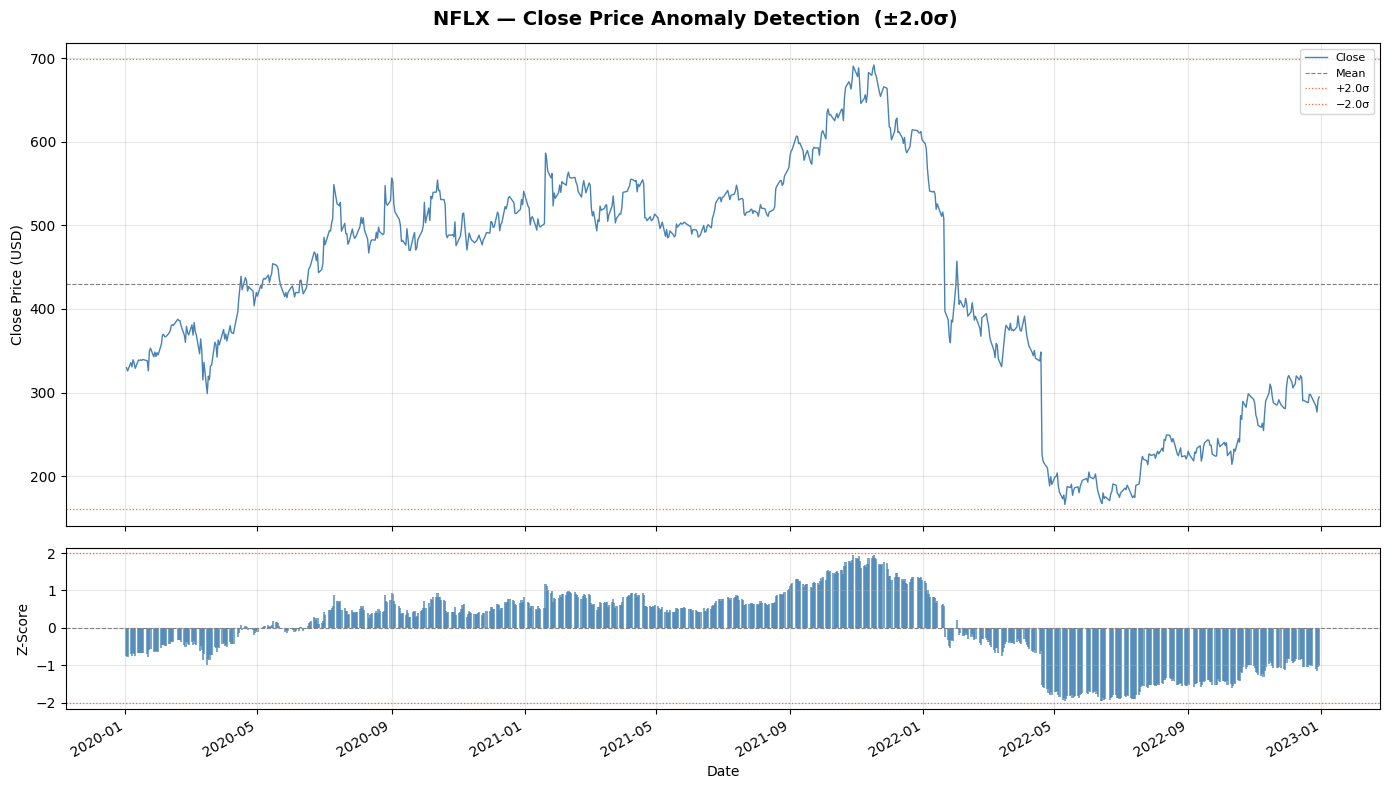

Chart saved to anomaly_chart.png


In [19]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True,
                                gridspec_kw={"height_ratios": [3, 1]})
fig.suptitle(f"{SYMBOL} — {PRICE_COL} Price Anomaly Detection  (±{K_THRESHOLD}σ)",
             fontsize=14, fontweight="bold")

# ── Top panel: price series + anomalies ──────────────────────────────────
ax1.plot(df["Date"], df[PRICE_COL], color="steelblue", linewidth=1, label=PRICE_COL)
ax1.axhline(mean,           color="grey",   linestyle="--", linewidth=0.8, label="Mean")
ax1.axhline(mean + K_THRESHOLD * std_dev, color="tomato", linestyle=":",
            linewidth=0.9, label=f"+{K_THRESHOLD}σ")
ax1.axhline(mean - K_THRESHOLD * std_dev, color="tomato", linestyle=":",
            linewidth=0.9, label=f"−{K_THRESHOLD}σ")

if len(anomalies):
    above = anomalies[anomalies[PRICE_COL] > mean]
    below = anomalies[anomalies[PRICE_COL] <= mean]
    ax1.scatter(above["Date"], above[PRICE_COL], color="tomato",  zorder=5,
                label="Anomaly ↑", s=40)
    ax1.scatter(below["Date"], below[PRICE_COL], color="darkorange", zorder=5,
                label="Anomaly ↓", s=40)

ax1.set_ylabel(f"{PRICE_COL} Price (USD)")
ax1.legend(fontsize=8)
ax1.grid(True, alpha=0.3)

# ── Bottom panel: z-score ─────────────────────────────────────────────────
ax2.bar(df["Date"], df["z_score"],
        color=["tomato" if a else "steelblue" for a in df["is_anomaly"]],
        width=2, alpha=0.7)
ax2.axhline( K_THRESHOLD, color="tomato", linestyle=":", linewidth=0.9)
ax2.axhline(-K_THRESHOLD, color="tomato", linestyle=":", linewidth=0.9)
ax2.axhline(0, color="grey", linestyle="--", linewidth=0.8)
ax2.set_ylabel("Z-Score")
ax2.set_xlabel("Date")
ax2.grid(True, alpha=0.3)

ax2.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
fig.autofmt_xdate(rotation=30)
plt.tight_layout()
plt.savefig("anomaly_chart.png", dpi=150, bbox_inches="tight")
plt.show()
print("Chart saved to anomaly_chart.png")